In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!pip install folium
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Libraries imported!')

     |████████████████████████████████| 102kB 9.7MB/s eta 0:00:01
Libraries imported!


In [3]:
CLIENT_ID = 'QOQGGJQD40KCHZPJONE2N1HDMK134HLVKEROCWR2B1RWUA41' 
CLIENT_SECRET = 'VK00IL3Z5NM43DK5EJQD23MU2UD32I0BCSAZAV2HNXEPG5WM' 
VERSION = '20190605' 

In [17]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    print(url)
    results = requests.get(url).json()
    print(results)
    try:
        venue_data=results["response"]['groups'][0]['items']
    except:
        print("Some Exception")
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [18]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


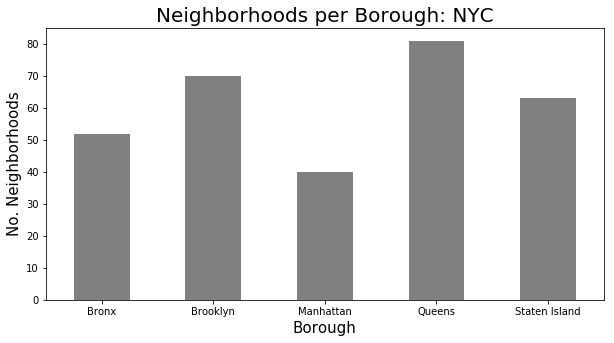

In [19]:
clr = "grey"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [20]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    print(row)
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
https://api.foursquare.com/v2/venues/explore?&client_id=QOQGGJQD40KCHZPJONE2N1HDMK134HLVKEROCWR2B1RWUA41&client_secret=VK00IL3Z5NM43DK5EJQD23MU2UD32I0BCSAZAV2HNXEPG5WM&v=20190605&ll=40.89470517661,-73.84720052054902&radius=400&limit=100
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ef0df1a9388d7001bdfc3b5'}, 'response': {}}
Some Exception


UnboundLocalError: local variable 'venue_data' referenced before assignment

In [13]:
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [14]:
indian_rest_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name


In [15]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

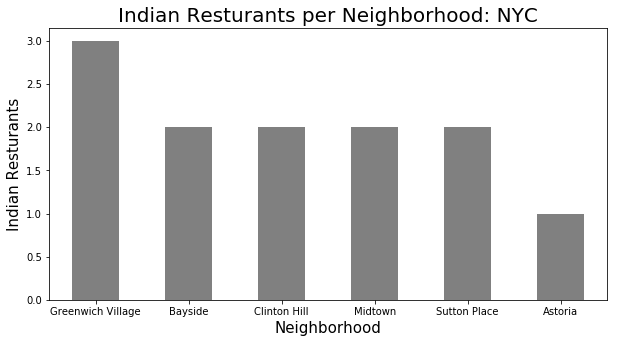

In [20]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [33]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [36]:
for row in indian_rest_ny.values.tolist():
    print(row)
    ID1,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

[0, 'Bronx', 'Woodlawn', '4c0448d9310fc9b6bf1dc761', 'Curry Spot']
{'meta': {'code': 200, 'requestId': '5ef0cb2c0be7b4001b129be4'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https:

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
33,Manhattan,Noho,5a1e961c1987ec47beed877d,Baar Baar,152,8.5,34
34,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.2,6
35,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.5,58
36,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.3,83
37,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden,17,7.7,16


In [37]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv')

In [38]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
Borough         38 non-null object
Neighborhood    38 non-null object
ID              38 non-null object
Name            38 non-null object
Likes           38 non-null float64
Rating          38 non-null float64
Tips            38 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.2+ KB


In [39]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,38.000000,38.000000,38.000000
mean,94.868421,7.384211,32.447368
std,174.621780,1.961319,52.425338
min,0.000000,0.000000,0.000000
25%,12.500000,7.325000,6.000000
50%,30.000000,8.000000,15.000000
75%,80.000000,8.300000,24.250000
max,834.000000,8.900000,258.000000


In [41]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.3
Tips                                 258
Name: 19, dtype: object

In [42]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.9
Tips                                 148
Name: 23, dtype: object

In [43]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.3
Tips                                 258
Name: 19, dtype: object

In [44]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
24,Tribeca,8.900000
7,Fort Greene,8.800000
20,Prospect Lefferts Gardens,8.600000
28,West Village,8.600000
10,Greenwich Village,8.566667
19,Noho,8.500000
23,Sutton Place,8.400000
17,Midtown,8.350000
0,Astoria,8.300000
18,New Dorp,8.100000


In [46]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.237500
4,Staten Island,8.100000
1,Brooklyn,7.390000
0,Bronx,7.000000
3,Queens,5.866667


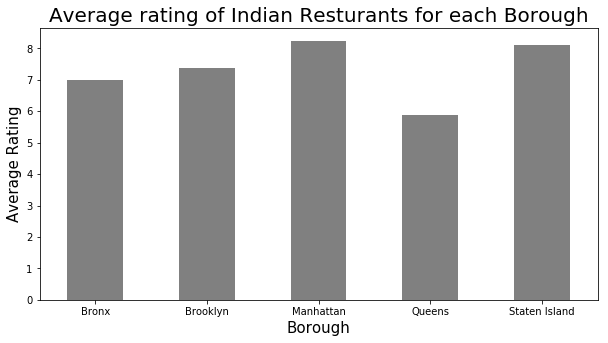

In [48]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [49]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.300000
3,Boerum Hill,8.000000
7,Fort Greene,8.800000
10,Greenwich Village,8.566667
13,Kew Gardens,8.000000
17,Midtown,8.350000
18,New Dorp,8.100000
19,Noho,8.500000
20,Prospect Lefferts Gardens,8.600000
23,Sutton Place,8.400000


In [50]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.300000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.000000
2,Brooklyn,Fort Greene,40.688527,-73.972906,8.800000
3,Manhattan,Greenwich Village,40.726933,-73.999914,8.566667
4,Queens,Kew Gardens,40.705179,-73.829819,8.000000
5,Manhattan,Midtown,40.754691,-73.981669,8.350000
6,Staten Island,New Dorp,40.572572,-74.116479,8.100000
7,Manhattan,Noho,40.723259,-73.988434,8.500000
8,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.600000
9,Manhattan,Sutton Place,40.760280,-73.963556,8.400000


In [51]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [52]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)